In [1]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import SpectralEmbedding
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.cluster.hierarchy import ward, fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import output_notebook
import numpy as np
from collections import defaultdict
import unicodedata
from rapidfuzz import process
from rapidfuzz.fuzz import token_sort_ratio
from scipy.stats import wasserstein_distance
from itertools import combinations
from scipy.sparse import csr_matrix

In [50]:
le_df = pd.read_csv(r"C:\Users\vaugh\Desktop\basketball-pf-research\Important DataFrames\le_df.csv").drop(columns = ['Unnamed: 0'])

# Creating Pear Plot to Test Trendiness Proxies

In [91]:
%store -r game_log_dfs

In [92]:
game_log_dfs['2002HOU']

,Opponent,Result
0,2002ATL,W
1,2002LAC,W
2,2002MIN,L
3,2002PHO,W
4,2002DEN,W
...,...,...
80,2002DAL,W
81,2002POR,L
82,2002MEM,L
84,2002DEN,L


In [93]:
le_df

,Roster,LE_Component_1,LE_Component_2,Win_Percentage,Avg Height,Standard Deviation of Roster Height,Season,Distance
0,2001ATL,0.001939,0.005253,0.304878,79.7,4.73,2001,0.003596
1,2001BOS,0.000370,0.001861,0.439024,79.3,3.68,2001,0.001115
2,2001CHH,0.002602,0.002443,0.560976,80.0,3.83,2001,0.002522
3,2001CHI,-0.002554,0.001034,0.182927,78.3,3.60,2001,-0.000760
4,2001CLE,-0.000043,-0.002858,0.365854,79.4,2.62,2001,-0.001450
...,...,...,...,...,...,...,...,...
691,2024SAC,-0.001839,-0.001672,0.560976,78.7,2.60,2024,-0.001756
692,2024SAS,-0.000642,-0.001415,0.268293,79.4,3.73,2024,-0.001028
693,2024TOR,-0.002939,-0.002066,0.304878,78.4,2.84,2024,-0.002503
694,2024UTA,0.000223,0.000589,0.378049,79.4,3.70,2024,0.000406


In [94]:
practice_df = le_df.copy()
practice_df['Avg Height'] = practice_df.groupby('Season')['Avg Height'].transform(lambda x: (x - x.mean()) / x.std())

In [95]:
practice_df

,Roster,LE_Component_1,LE_Component_2,Win_Percentage,Avg Height,Standard Deviation of Roster Height,Season,Distance
0,2001ATL,0.001939,0.005253,0.304878,0.227966,4.73,2001,0.003596
1,2001BOS,0.000370,0.001861,0.439024,-0.311708,3.68,2001,0.001115
2,2001CHH,0.002602,0.002443,0.560976,0.632721,3.83,2001,0.002522
3,2001CHI,-0.002554,0.001034,0.182927,-1.660894,3.60,2001,-0.000760
4,2001CLE,-0.000043,-0.002858,0.365854,-0.176790,2.62,2001,-0.001450
...,...,...,...,...,...,...,...,...
691,2024SAC,-0.001839,-0.001672,0.560976,-0.470443,2.60,2024,-0.001756
692,2024SAS,-0.000642,-0.001415,0.268293,0.614784,3.73,2024,-0.001028
693,2024TOR,-0.002939,-0.002066,0.304878,-0.935540,2.84,2024,-0.002503
694,2024UTA,0.000223,0.000589,0.378049,0.614784,3.70,2024,0.000406


In [102]:
ex = pd.DataFrame(
        np.nan,
        index=range(5),
        columns=range(5),
        dtype=float
    )
ex[1][2] = 0

In [103]:
ex

,0,1,2,3,4
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,0.0,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


In [150]:
np.round(practice_df.loc[practice_df['Season'] < 2010, 'Avg Height'].min(), 1)

-2.7

In [171]:
def make_pear_matrix(proxy, era, bins):
    pear_df = le_df[(le_df['Season'] >= era[0]) & (le_df['Season'] < era[1])].copy()
    pear_df['raw_' + proxy] = pear_df[proxy]
    pear_df[proxy] = pear_df.groupby('Season')[proxy].transform(lambda x: (x - x.mean()) / x.std())
    
    pear_df["proxy_bin"] = pd.qcut(
        pear_df[proxy],
        q=bins,
        labels=False,
        duplicates="drop"
    )
    
    reg_bin_labels = []
    z_bin_labels = []
    for bin_num in range(bins):
        reg_bin_df = pear_df.loc[pear_df['proxy_bin'] == bin_num, 'raw_' + proxy]
        reg_low_bound = np.round(reg_bin_df.min(), 1)
        reg_up_bound = np.round(reg_bin_df.max(), 1)
        reg_bin_labels.append(f'{reg_low_bound}-{reg_up_bound}')
        
        z_bin_df = pear_df.loc[pear_df['proxy_bin'] == bin_num, proxy]
        z_low_bound = np.round(z_bin_df.min(), 2)
        z_up_bound = np.round(z_bin_df.max(), 2)
        z_bin_labels.append(f'{z_low_bound}, {z_up_bound}')
    
    rosters_by_season_bin = {}
    for season in pear_df["Season"].unique():
        seasonsub = pear_df[pear_df["Season"] == season]
        rosters_by_season_bin[season] = {
            b: seasonsub.loc[seasonsub["proxy_bin"] == b, "Roster"].tolist()
            for b in range(bins)
        }
    
    matrix = pd.DataFrame(
        np.nan,
        index=range(bins),
        columns=range(bins),
        dtype=float
    )
    
    for i in range(bins):
        for j in range(bins):
            wins = 0
            games = 0
            for season in rosters_by_season_bin.keys():
                bin_i = rosters_by_season_bin[season][i]
                bin_j = rosters_by_season_bin[season][j]
                
                if not bin_i or not bin_j:
                    continue
                
                for roster in bin_i:
                    gl = game_log_dfs.get(roster)
                    if gl is None or gl.empty:
                        continue
                    
                    games += gl.loc[gl['Opponent'].isin(bin_j)].shape[0]
                    wins += gl.loc[(gl['Opponent'].isin(bin_j)) & (gl['Result'] == 'W')].shape[0]
            if games > 0:
                matrix[i][j] = np.round(wins / games, 2)
    
    if proxy == 'Avg Height':
        matrix.index = reg_bin_labels
        matrix.columns = reg_bin_labels
    else:
        matrix.index = z_bin_labels
        matrix.columns = z_bin_labels
    
    return matrix

def make_pear_plot(matrix, proxy, era):
    plt.figure(figsize=(6,5))
    ax = sns.heatmap(
        matrix,
        annot=True,
        fmt=".2f",
        cmap="RdYlGn",
        vmin=.3, vmax=.7,
        cbar_kws={"label": "Win %"},
        xticklabels=matrix.columns,
        yticklabels=matrix.index,
    )
    
    ax.invert_yaxis()
    if proxy == 'Avg Height':
        plt.xlabel(f"{proxy} Bins in inches (team)")
        plt.ylabel(f"{proxy} Bins in inches (opponent)")
        plt.title(f"Win % by {proxy} (Seasons {era[0]}–{era[1]-1})")
        plt.tight_layout()
        plt.show()
    else:
        plt.xlabel(f"{proxy} Bins in z-scores (team)")
        plt.ylabel(f"{proxy} Bins in z-scores (opponent)")
        plt.title(f"Win % by {proxy} (Seasons {era[0]}–{era[1]-1})")
        plt.tight_layout()
        plt.show()

In [130]:
make_pear_matrix('Avg Height', [2000, 2015], 5)

,0,1,2,3,4
0,0.50,0.53,0.56,0.60,0.53
1,0.47,0.50,0.51,0.55,0.50
2,0.44,0.49,0.50,0.51,0.49
3,0.40,0.45,0.49,0.50,0.46
4,0.47,0.50,0.51,0.54,0.50


In [173]:
le_df

,Roster,LE_Component_1,LE_Component_2,Win_Percentage,Avg Height,Standard Deviation of Roster Height,Season,Distance
0,2001ATL,0.001939,0.005253,0.304878,79.7,4.73,2001,0.003596
1,2001BOS,0.000370,0.001861,0.439024,79.3,3.68,2001,0.001115
2,2001CHH,0.002602,0.002443,0.560976,80.0,3.83,2001,0.002522
3,2001CHI,-0.002554,0.001034,0.182927,78.3,3.60,2001,-0.000760
4,2001CLE,-0.000043,-0.002858,0.365854,79.4,2.62,2001,-0.001450
...,...,...,...,...,...,...,...,...
691,2024SAC,-0.001839,-0.001672,0.560976,78.7,2.60,2024,-0.001756
692,2024SAS,-0.000642,-0.001415,0.268293,79.4,3.73,2024,-0.001028
693,2024TOR,-0.002939,-0.002066,0.304878,78.4,2.84,2024,-0.002503
694,2024UTA,0.000223,0.000589,0.378049,79.4,3.70,2024,0.000406


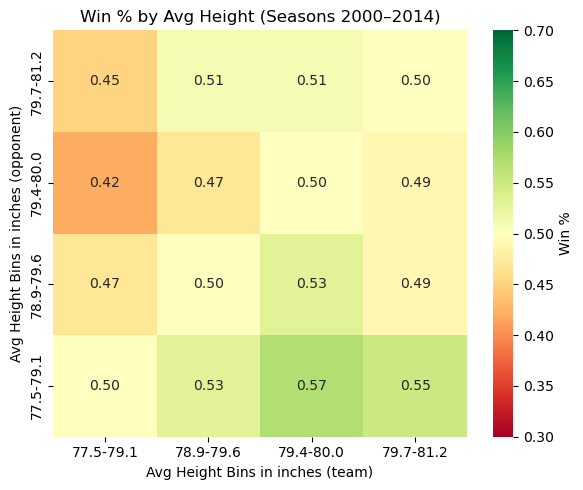

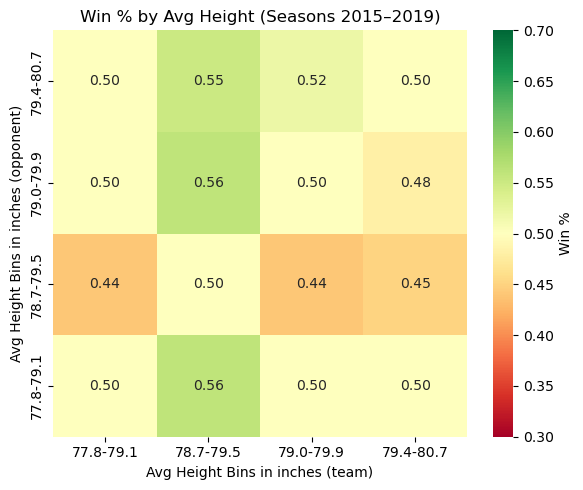

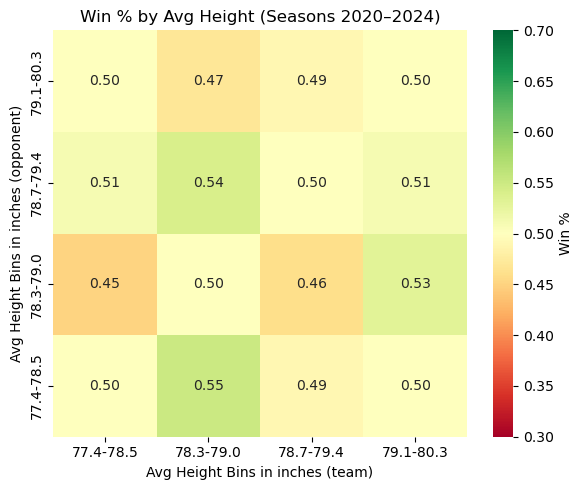

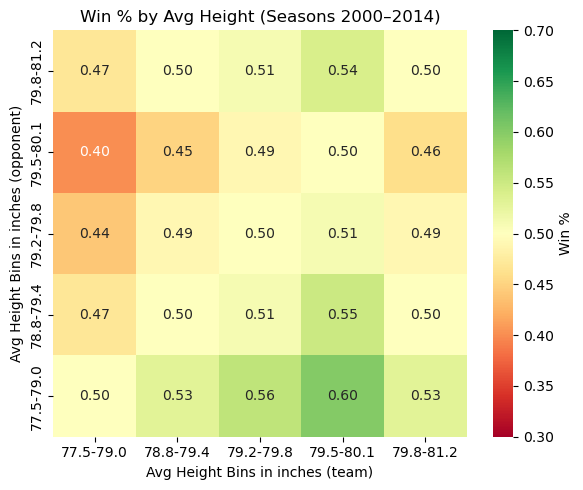

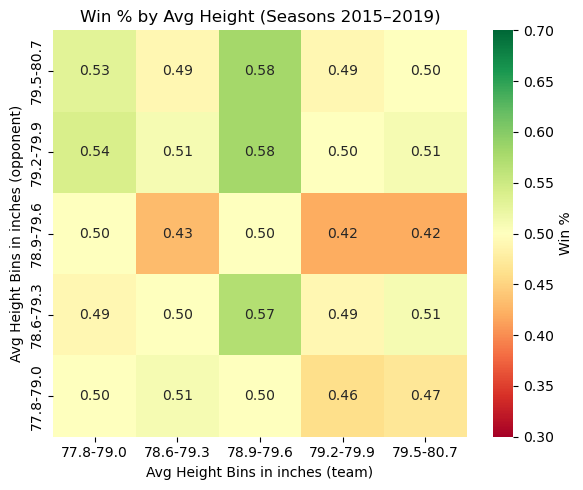

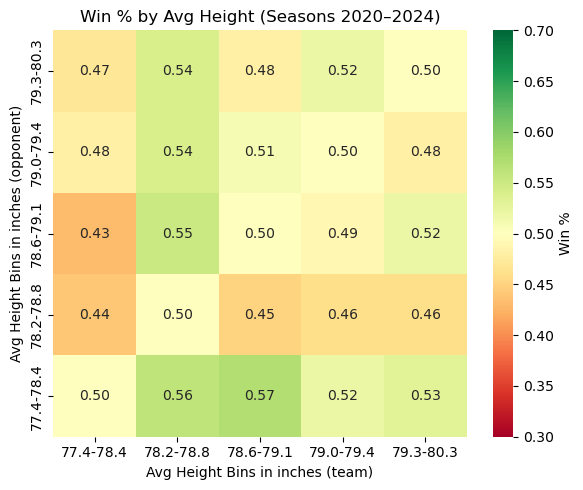

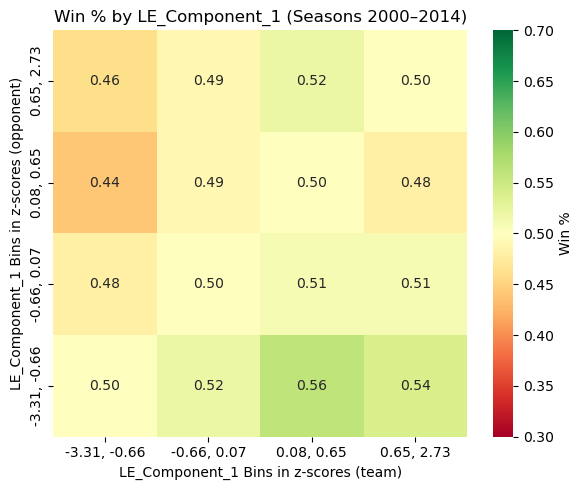

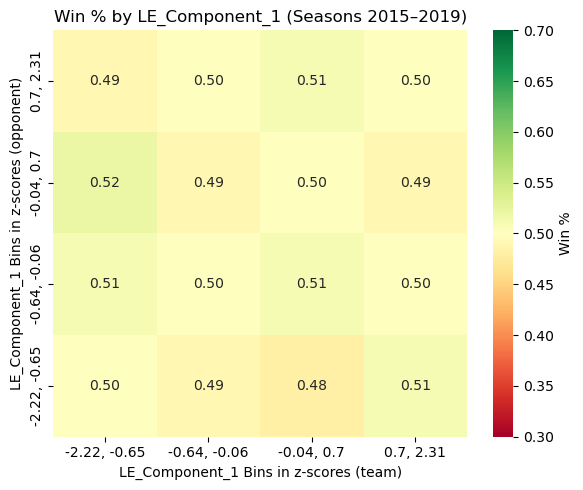

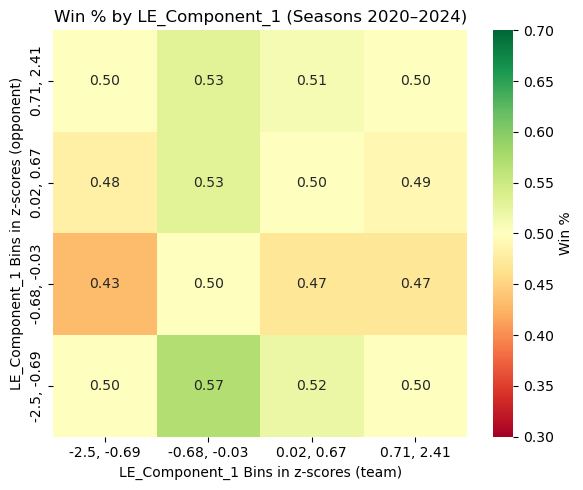

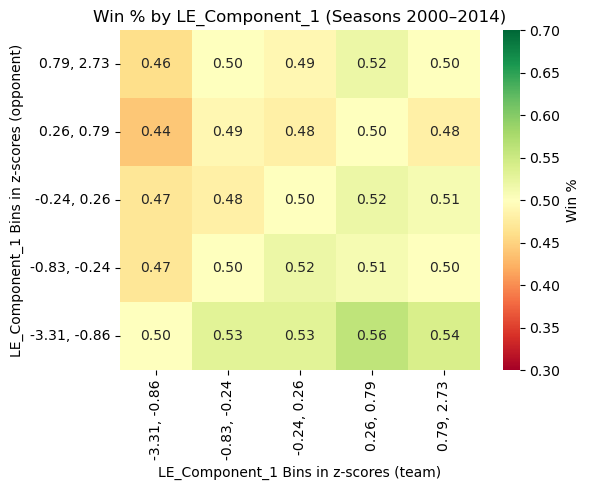

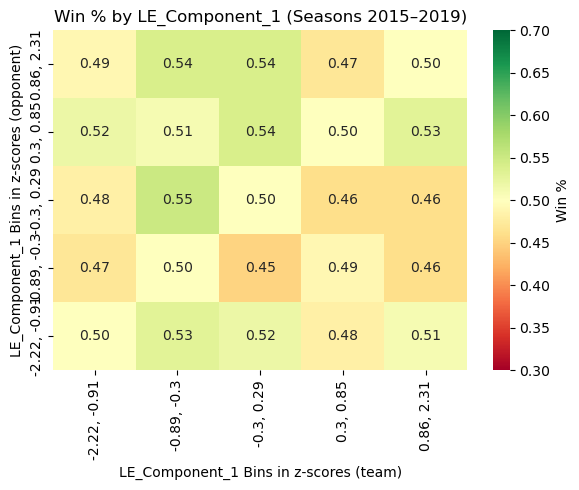

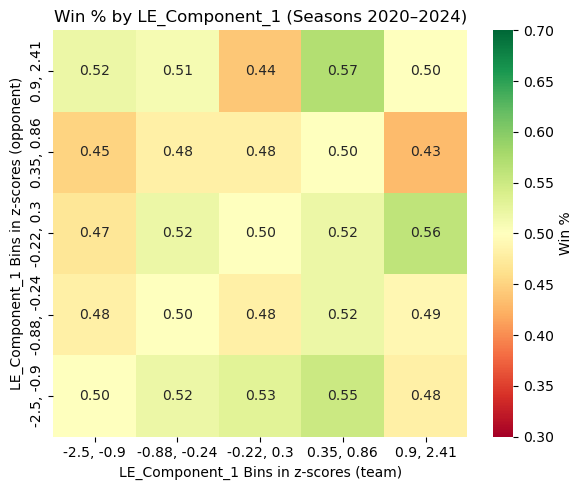

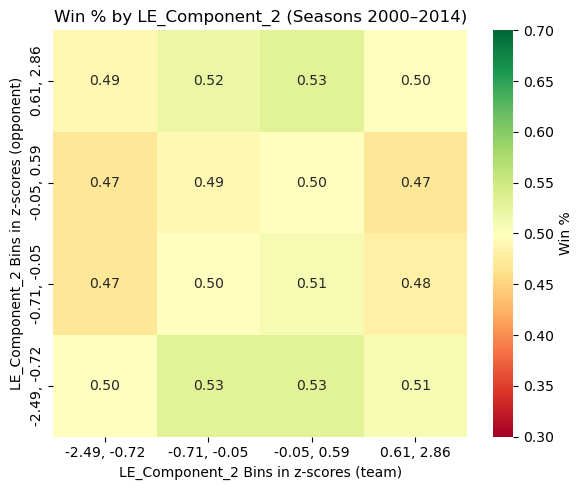

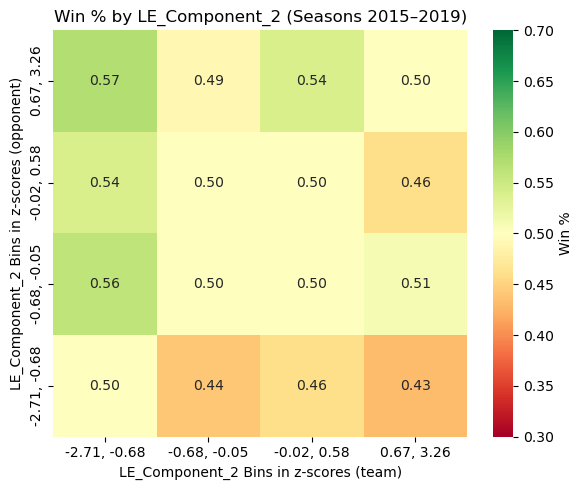

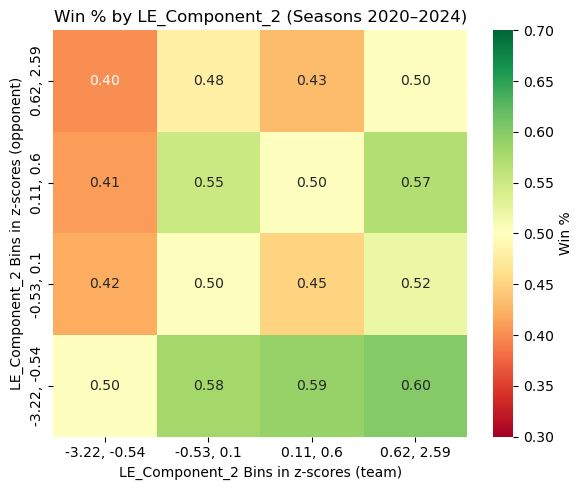

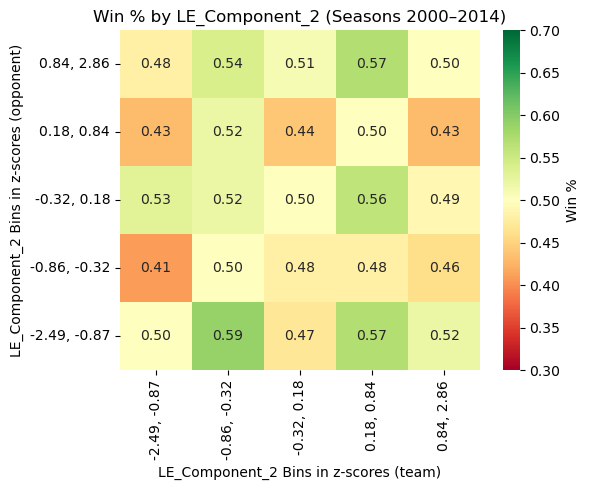

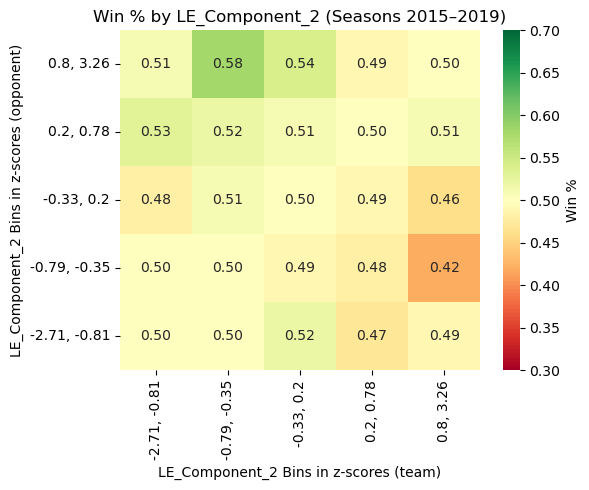

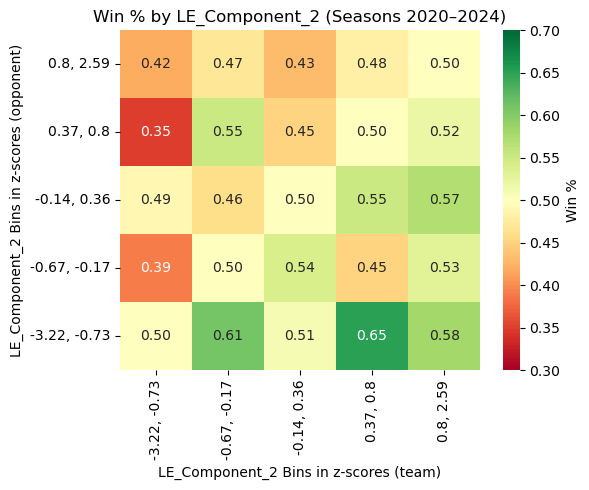

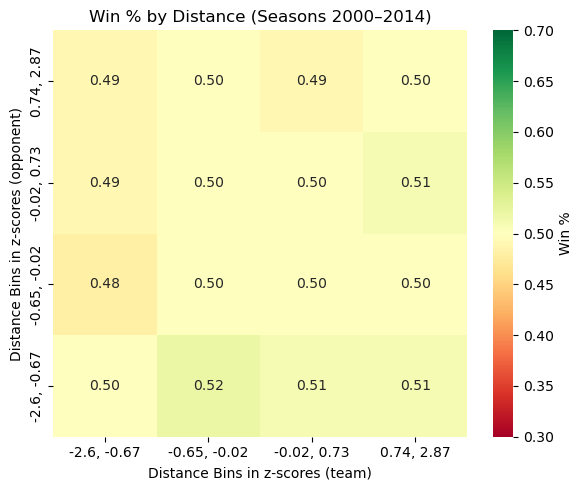

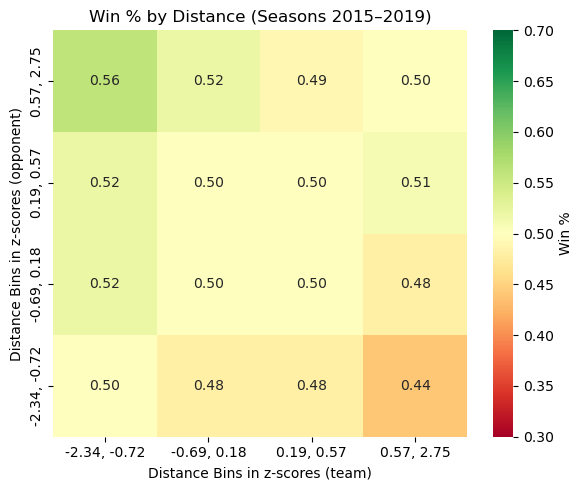

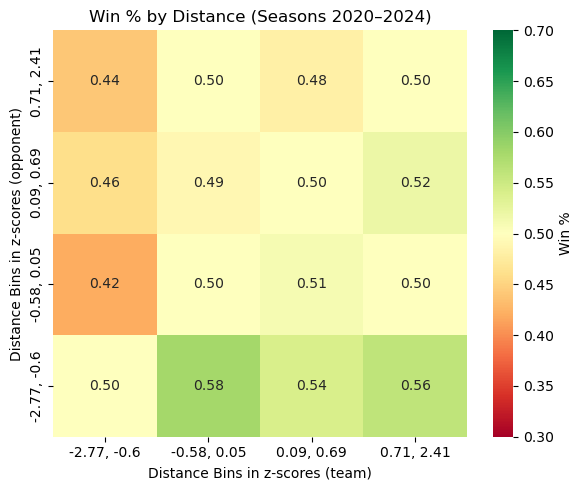

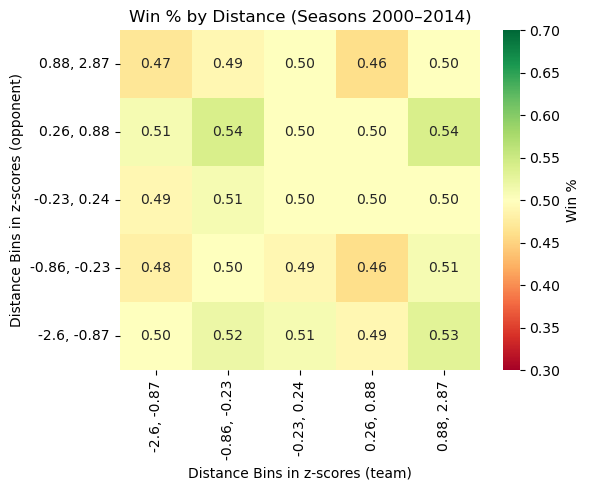

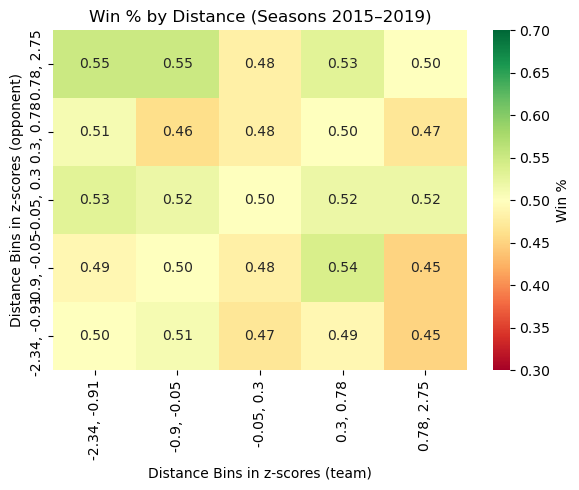

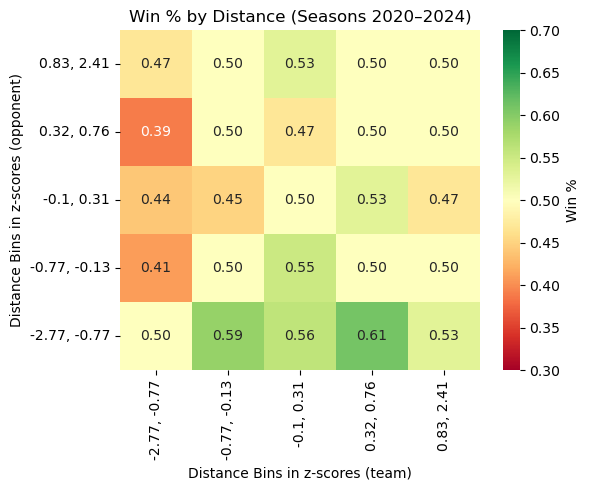

In [175]:
eras = [[2000, 2015], [2015, 2020], [2020, 2025]]
proxies = ['Avg Height', 'LE_Component_1', 'LE_Component_2', 'Distance']
bins = [4,5]
for proxy in proxies:
    for b in bins:
        for era in eras:
            make_pear_plot(make_pear_matrix(proxy, era, b), proxy, era)

In [101]:
game_log_dfs.get('2001CHI')

,Opponent,Result
0,2001SAC,L
1,2001NJN,L
2,2001IND,L
3,2001WAS,L
4,2001ORL,W
...,...,...
80,2001WAS,W
81,2001UTA,L
82,2001IND,L
84,2001NJN,W


In [100]:
game_log_dfs['2001CHI'].loc[(game_log_dfs['2001CHI']['Opponent'].isin(['2001CHI', '2001DET', '2001MIA', '2001NYK', '2001WAS'])) & (game_log_dfs['2001CHI']['Result'] == 'W')]

,Opponent,Result
32,2001WAS,W
51,2001MIA,W
58,2001NYK,W
80,2001WAS,W


# Making Bar Charts to Show Win% of Trendy vs Non-Trendy

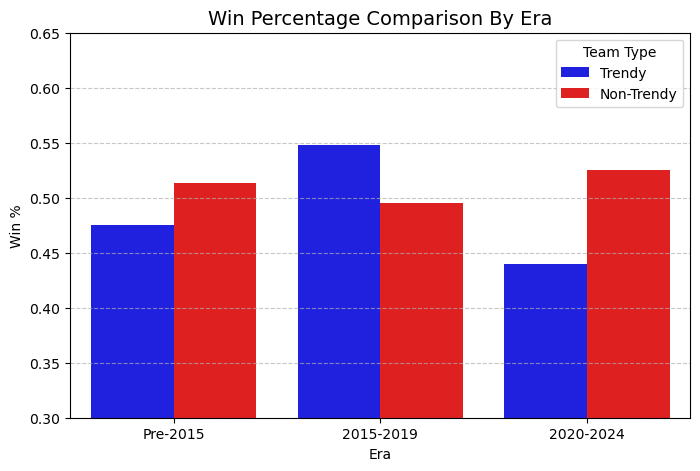

In [29]:
# Creating a bar plot to show the results of trendiness in different "eras"

eras = ['Pre-2015', '2015-2019', '2020-2024']
trendy_win_pct = [trendy_pre2015, trendy_2015_2019, trendy_2020_2024]
non_trendy_win_pct = [non_trendy_pre2015, non_trendy_2015_2019, non_trendy_2020_2024]

eras_df = pd.DataFrame({
    "Era": eras * 2,
    "Win %": trendy_win_pct + non_trendy_win_pct,
    "Team Type": ['Trendy'] * 3 + ['Non-Trendy'] * 3
})

plt.figure(figsize=(8,5))
sns.barplot(x="Era", y="Win %", hue="Team Type", data=eras_df, palette=['blue', 'red'])
plt.title('Win Percentage Comparison By Era', fontsize=14)
plt.ylabel('Win %')
plt.ylim(.3, .65)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [30]:
# Creating a table to show the results of trendiness in different "eras"

# Define the data
data = {
    "Era": ["Pre-2015", "2015-2019", "2020-2024"],
    "Trendy Teams Win%": [trendy_pre2015, trendy_2015_2019, trendy_2020_2024],
    "Non-Trendy Teams Win%": [non_trendy_pre2015, non_trendy_2015_2019, non_trendy_2020_2024]
}

# Create DataFrame
df = pd.DataFrame(data)

# Convert win% values to percentage format (without trailing zeros)
df[["Trendy Teams Win%", "Non-Trendy Teams Win%"]] = df[["Trendy Teams Win%", "Non-Trendy Teams Win%"]].applymap(lambda x: f"{round(x * 100)}%")

# Determine which group was more successful
df["More Successful"] = df.apply(lambda row: "Trendy" if float(row["Trendy Teams Win%"][:-1]) > float(row["Non-Trendy Teams Win%"][:-1]) else "Non-Trendy", axis=1)

# Display the table in a Jupyter Notebook
df

,Era,Trendy Teams Win%,Non-Trendy Teams Win%,More Successful
0,Pre-2015,47%,51%,Non-Trendy
1,2015-2019,55%,50%,Trendy
2,2020-2024,44%,53%,Non-Trendy


In [31]:
trend_wins_df = pd.read_csv(r"C:\Users\vaugh\Desktop\basketball-pf-research\Important DataFrames\team_trend_win_percentages.csv")

In [32]:
trend_wins_df

,Roster,Trendy,Not-Trendy,Neither
0,2001MIA,0.714286,0.562500,0.577778
1,2001CHI,0.266667,0.222222,0.142857
2,2001PHI,0.900000,0.750000,0.580000
3,2001NJN,0.368421,0.333333,0.288889
4,2001GSW,0.300000,0.166667,0.200000
...,...,...,...,...
711,2024MEM,0.307692,0.230769,0.357143
712,2024OKC,0.800000,0.571429,0.706897
713,2024BRK,0.545455,0.312500,0.381818
714,2024NOP,0.461538,0.428571,0.666667


In [33]:
extremes_df = le_df[le_df['Roster'].isin(trend_teams)]
extremes_df = pd.merge(extremes_df, trend_wins_df, on='Roster')

In [34]:
extremes_df[extremes_df['Season'] == 2001]

,Roster,LE_Component_1,LE_Component_2,Win_Percentage,Avg Height,Standard Deviation of Roster Height,Season,Distance,Trendy,Not-Trendy,Neither
0,2001ATL,0.001939,0.005253,0.304878,79.7,4.73,2001,0.003596,0.400000,0.230769,0.285714
1,2001CHH,0.002602,0.002443,0.560976,80.0,3.83,2001,0.002522,0.526316,0.642857,0.551020
2,2001CHI,-0.002554,0.001034,0.182927,78.3,3.60,2001,-0.000760,0.266667,0.222222,0.142857
3,2001CLE,-0.000043,-0.002858,0.365854,79.4,2.62,2001,-0.001450,0.562500,0.333333,0.312500
4,2001DET,-0.003685,0.002772,0.390244,77.9,4.03,2001,-0.000457,0.571429,0.388889,0.340000
5,2001IND,0.005563,0.000329,0.500000,80.9,3.44,2001,0.002946,0.800000,0.230769,0.448980
6,2001NYK,-0.002027,0.000353,0.585366,78.6,3.14,2001,-0.000837,0.733333,0.470588,0.580000
7,2001PHI,0.003722,0.001667,0.682927,80.4,3.99,2001,0.002695,0.900000,0.750000,0.580000
8,2001POR,0.003327,0.004739,0.609756,79.9,4.90,2001,0.004033,0.800000,0.750000,0.562500
9,2001WAS,-0.003732,-0.002475,0.231707,78.1,2.62,2001,-0.003103,0.357143,0.222222,0.200000


In [35]:
# "Trendy" teams win% versus other trendy teams before 2015
trendy_trendy_15 = extremes_df[extremes_df['Roster'].isin(trendy_teams) & (extremes_df['Season'] < 2015)].get('Trendy').mean()
# "Trendy" teams win% versus non trendy teams before 2015
trendy_untrendy_15 = extremes_df[extremes_df['Roster'].isin(trendy_teams) & (extremes_df['Season'] < 2015)].get('Not-Trendy').mean()
# "Trendy" teams win% versus neutral teams before 2015
trendy_neither_15 = extremes_df[extremes_df['Roster'].isin(trendy_teams) & (extremes_df['Season'] < 2015)].get('Neither').mean()

In [36]:
# "Unrendy" teams win% versus other trendy teams before 2015
untrendy_trendy_15 = extremes_df[extremes_df['Roster'].isin(untrendy_teams) & (extremes_df['Season'] < 2015)].get('Trendy').mean()
# "Untrendy" teams win% versus non trendy teams before 2015
untrendy_untrendy_15 = extremes_df[extremes_df['Roster'].isin(untrendy_teams) & (extremes_df['Season'] < 2015)].get('Not-Trendy').mean()
# "Untrendy" teams win% versus neutral teams before 2015
untrendy_neither_15 = extremes_df[extremes_df['Roster'].isin(untrendy_teams) & (extremes_df['Season'] < 2015)].get('Neither').mean()

In [37]:
# "Trendy" teams win% versus other trendy teams between 2015 and 2019
trendy_trendy_19 = extremes_df[extremes_df['Roster'].isin(trendy_teams) & (extremes_df['Season'] >= 2015) & (extremes_df['Season'] < 2020)].get('Trendy').mean()
# "Trendy" teams win% versus non trendy teams between 2015 and 2019
trendy_untrendy_19 = extremes_df[extremes_df['Roster'].isin(trendy_teams) & (extremes_df['Season'] >= 2015) & (extremes_df['Season'] < 2020)].get('Not-Trendy').mean()
# "Trendy" teams win% versus neutral teams between 2015 and 2019
trendy_neither_19 = extremes_df[extremes_df['Roster'].isin(trendy_teams) & (extremes_df['Season'] >= 2015) & (extremes_df['Season'] < 2020)].get('Neither').mean()

In [38]:
# "Untrendy" teams win% versus other trendy teams between 2015 and 2019
untrendy_trendy_19 = extremes_df[extremes_df['Roster'].isin(untrendy_teams) & (extremes_df['Season'] >= 2015) & (extremes_df['Season'] < 2020)].get('Trendy').mean()
# "Untrendy" teams win% versus non trendy teams between 2015 and 2019
untrendy_untrendy_19 = extremes_df[extremes_df['Roster'].isin(untrendy_teams) & (extremes_df['Season'] >= 2015) & (extremes_df['Season'] < 2020)].get('Not-Trendy').mean()
# "Untrendy" teams win% versus neutral teams between 2015 and 2019
untrendy_neither_19 = extremes_df[extremes_df['Roster'].isin(untrendy_teams) & (extremes_df['Season'] >= 2015) & (extremes_df['Season'] < 2020)].get('Neither').mean()

In [39]:
# "Trendy" teams win% versus other trendy teams between 2020 and 2024
trendy_trendy_24 = extremes_df[extremes_df['Roster'].isin(trendy_teams) & (extremes_df['Season'] >= 2020)].get('Trendy').mean()
# "Trendy" teams win% versus non trendy teams between 2020 and 2024
trendy_untrendy_24 = extremes_df[extremes_df['Roster'].isin(trendy_teams) & (extremes_df['Season'] >= 2020)].get('Not-Trendy').mean()
# "Trendy" teams win% versus neutral teams between 2020 and 2024
trendy_neither_24 = extremes_df[extremes_df['Roster'].isin(trendy_teams) & (extremes_df['Season'] >= 2020)].get('Neither').mean()

In [40]:
# "Untrendy" teams win% versus other trendy teams between 2020 and 2024
untrendy_trendy_24 = extremes_df[extremes_df['Roster'].isin(untrendy_teams) & (extremes_df['Season'] >= 2020)].get('Trendy').mean()
# "Untrendy" teams win% versus non trendy teams between 2020 and 2024
untrendy_untrendy_24 = extremes_df[extremes_df['Roster'].isin(untrendy_teams) & (extremes_df['Season'] >= 2020)].get('Not-Trendy').mean()
# "Untrendy" teams win% versus neutral teams between 2020 and 2024
untrendy_neither_24 = extremes_df[extremes_df['Roster'].isin(untrendy_teams) & (extremes_df['Season'] >= 2020)].get('Neither').mean()

In [41]:
# "Trendy" teams win% versus other trendy teams 2019
trendy_trendy_2015 = extremes_df[extremes_df['Roster'].isin(trendy_teams) & (extremes_df['Season'] == 2015)].get('Trendy').mean()
# "Trendy" teams win% versus non trendy teams 2019
trendy_untrendy_2015 = extremes_df[extremes_df['Roster'].isin(trendy_teams) & (extremes_df['Season'] == 2015)].get('Not-Trendy').mean()
# "Trendy" teams win% versus neutral teams 2019
trendy_neither_2015 = extremes_df[extremes_df['Roster'].isin(trendy_teams) & (extremes_df['Season'] == 2015)].get('Neither').mean()

In [42]:
# "Untrendy" teams win% versus other trendy teams 2019
untrendy_trendy_2015 = extremes_df[extremes_df['Roster'].isin(untrendy_teams) & (extremes_df['Season'] == 2015)].get('Trendy').mean()
# "Untrendy" teams win% versus non trendy teams 2019
untrendy_untrendy_2015 = extremes_df[extremes_df['Roster'].isin(untrendy_teams) & (extremes_df['Season'] == 2015)].get('Not-Trendy').mean()
# "Untrendy" teams win% versus neutral teams 2019
untrendy_neither_2015 = extremes_df[extremes_df['Roster'].isin(untrendy_teams) & (extremes_df['Season'] == 2015)].get('Neither').mean()

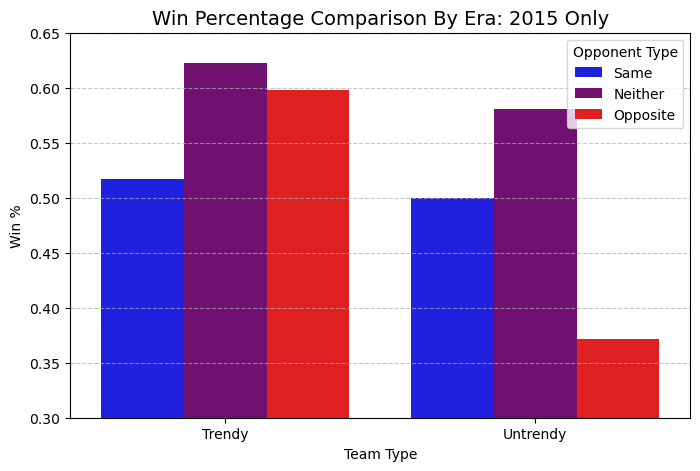

In [43]:
# Creating a bar plot to show the results of trendiness before 2015

trendy_win_pct_15 = [trendy_trendy_2015, trendy_neither_2015, trendy_untrendy_2015]
untrendy_win_pct_15 = [untrendy_untrendy_2015, untrendy_neither_2015, untrendy_trendy_2015]

eras_df_15 = pd.DataFrame({
    "Team Type": ['Trendy'] * 3 + ['Untrendy'] * 3,
    "Win %": trendy_win_pct_15 + untrendy_win_pct_15,
    "Opponent Type": ['Same', 'Neither', 'Opposite'] * 2
})

plt.figure(figsize=(8,5))
sns.barplot(x="Team Type", y="Win %", hue="Opponent Type", data=eras_df_15, palette=['blue', 'purple', 'red'])
plt.title('Win Percentage Comparison By Era: 2015 Only', fontsize=14)
plt.ylabel('Win %')
plt.ylim(.3, .65)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

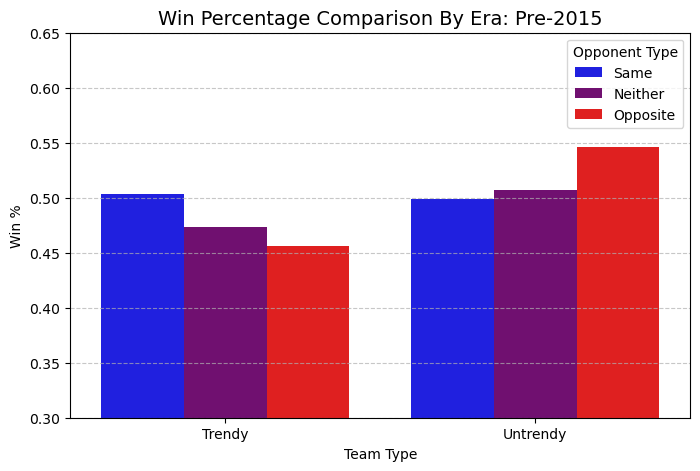

In [44]:
# Creating a bar plot to show the results of trendiness before 2015

trendy_win_pct_2015 = [trendy_trendy_15, trendy_neither_15, trendy_untrendy_15]
untrendy_win_pct_2015 = [untrendy_untrendy_15, untrendy_neither_15, untrendy_trendy_15]

eras_df_2015 = pd.DataFrame({
    "Team Type": ['Trendy'] * 3 + ['Untrendy'] * 3,
    "Win %": trendy_win_pct_2015 + untrendy_win_pct_2015,
    "Opponent Type": ['Same', 'Neither', 'Opposite'] * 2
})

plt.figure(figsize=(8,5))
sns.barplot(x="Team Type", y="Win %", hue="Opponent Type", data=eras_df_2015, palette=['blue', 'purple', 'red'])
plt.title('Win Percentage Comparison By Era: Pre-2015', fontsize=14)
plt.ylabel('Win %')
plt.ylim(.3, .65)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

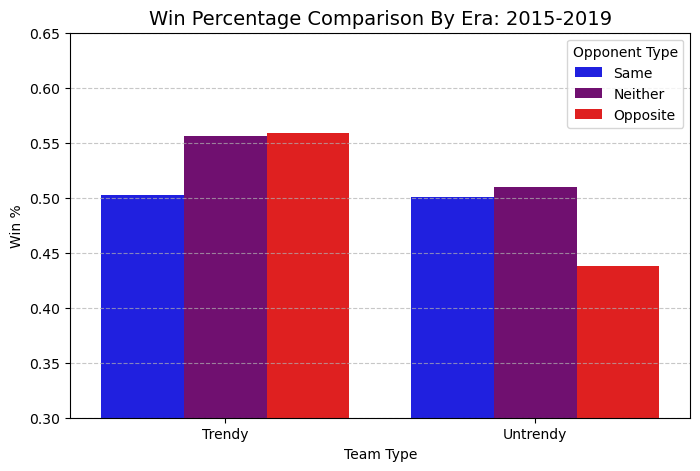

In [45]:
# Creating a bar plot to show the results of trendiness between 2015 and 2019

trendy_win_pct_2019 = [trendy_trendy_19, trendy_neither_19, trendy_untrendy_19]
untrendy_win_pct_2019 = [untrendy_untrendy_19, untrendy_neither_19, untrendy_trendy_19]

eras_df_2019 = pd.DataFrame({
    "Team Type": ['Trendy'] * 3 + ['Untrendy'] * 3,
    "Win %": trendy_win_pct_2019 + untrendy_win_pct_2019,
    "Opponent Type": ['Same', 'Neither', 'Opposite'] * 2
})

plt.figure(figsize=(8,5))
sns.barplot(x="Team Type", y="Win %", hue="Opponent Type", data=eras_df_2019, palette=['blue', 'purple', 'red'])
plt.title('Win Percentage Comparison By Era: 2015-2019', fontsize=14)
plt.ylabel('Win %')
plt.ylim(.3, .65)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

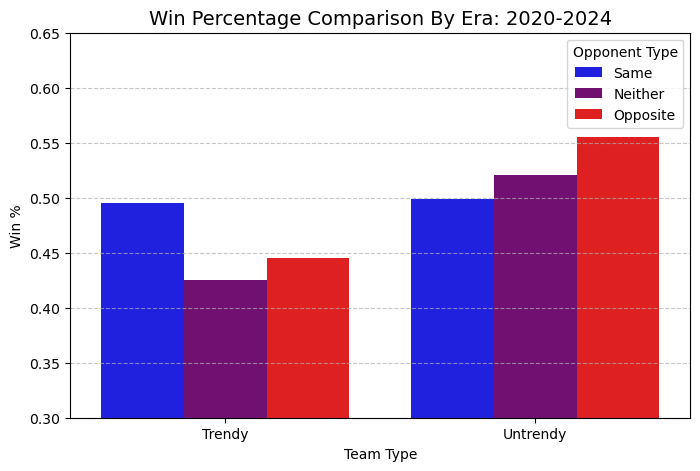

In [46]:
# Creating a bar plot to show the results of trendiness between 2015 and 2019

trendy_win_pct_2024 = [trendy_trendy_24, trendy_neither_24, trendy_untrendy_24]
untrendy_win_pct_2024 = [untrendy_untrendy_24, untrendy_neither_24, untrendy_trendy_24]

eras_df_2024 = pd.DataFrame({
    "Team Type": ['Trendy'] * 3 + ['Untrendy'] * 3,
    "Win %": trendy_win_pct_2024 + untrendy_win_pct_2024,
    "Opponent Type": ['Same', 'Neither', 'Opposite'] * 2
})

plt.figure(figsize=(8,5))
sns.barplot(x="Team Type", y="Win %", hue="Opponent Type", data=eras_df_2024, palette=['blue', 'purple', 'red'])
plt.title('Win Percentage Comparison By Era: 2020-2024', fontsize=14)
plt.ylabel('Win %')
plt.ylim(.3, .65)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Testing Statistical Significance of Trendy vs Non-Trendy

In [51]:
le_df

,Roster,LE_Component_1,LE_Component_2,Win_Percentage,Avg Height,Standard Deviation of Roster Height,Season,Distance
0,2001ATL,0.001939,0.005253,0.304878,79.7,4.73,2001,0.003596
1,2001BOS,0.000370,0.001861,0.439024,79.3,3.68,2001,0.001115
2,2001CHH,0.002602,0.002443,0.560976,80.0,3.83,2001,0.002522
3,2001CHI,-0.002554,0.001034,0.182927,78.3,3.60,2001,-0.000760
4,2001CLE,-0.000043,-0.002858,0.365854,79.4,2.62,2001,-0.001450
...,...,...,...,...,...,...,...,...
691,2024SAC,-0.001839,-0.001672,0.560976,78.7,2.60,2024,-0.001756
692,2024SAS,-0.000642,-0.001415,0.268293,79.4,3.73,2024,-0.001028
693,2024TOR,-0.002939,-0.002066,0.304878,78.4,2.84,2024,-0.002503
694,2024UTA,0.000223,0.000589,0.378049,79.4,3.70,2024,0.000406


In [53]:
trend_teams = []
trendy_teams = []
untrendy_teams = []
for season in le_df['Season'].unique():
    not_trend = list(le_df[le_df['Season'] == season].nlargest(5, 'Distance').get('Roster'))
    trend = list(le_df[le_df['Season'] == season].nsmallest(5, 'Distance').get('Roster'))
    trend_teams.extend(trend)
    trend_teams.extend(not_trend)
    trendy_teams.extend(trend)
    untrendy_teams.extend(not_trend)

In [54]:
# "Trendy" teams before 2015
trendy_pre2015 = le_df[le_df['Roster'].isin(trendy_teams) & (le_df['Season'] < 2015)].get('Win_Percentage').mean()
# "Non-trendy" teams before 2015
non_trendy_pre2015 = le_df[le_df['Roster'].isin(untrendy_teams) & (le_df['Season'] < 2015)].get('Win_Percentage').mean()
# "Trendy" teams between 2015-2019
trendy_2015_2019 = le_df[le_df['Roster'].isin(trendy_teams) & (le_df['Season'] >= 2015) & (le_df['Season'] < 2020)].get('Win_Percentage').mean()
# "Non-trendy" teams between 2015-2019
non_trendy_2015_2019 = le_df[le_df['Roster'].isin(untrendy_teams) & (le_df['Season'] >= 2015) & (le_df['Season'] < 2020)].get('Win_Percentage').mean()
# "Trendy" teams 2020-2024
trendy_2020_2024 = le_df[le_df['Roster'].isin(trendy_teams) & (le_df['Season'] >= 2020)].get('Win_Percentage').mean()
# "Non-trendy" teams 2020-2024
non_trendy_2020_2024 = le_df[le_df['Roster'].isin(untrendy_teams) & (le_df['Season'] >= 2020)].get('Win_Percentage').mean()

In [55]:
# Define function to get a df with the trendy and untrendy teams from an era
def get_era_df(low_season, high_season):
    trendies = le_df[le_df['Roster'].isin(trendy_teams) & (le_df['Season'] >= low_season) & (le_df['Season'] < high_season)].get(['Roster', 'Win_Percentage'])
    trendies['Trendy'] = 'Yes'
    trendies = trendies.drop(columns=['Roster'])
    untrendies = le_df[le_df['Roster'].isin(untrendy_teams) & (le_df['Season'] >= low_season) & (le_df['Season'] < high_season)].get(['Roster', 'Win_Percentage'])
    untrendies['Trendy'] = 'No'
    untrendies = untrendies.drop(columns=['Roster'])
    
    return pd.concat([trendies, untrendies])


# Define function to perform permutation test
def permutation_test(data, team_col, win_col, year, num_reps=1000):
    observed_diff = data.groupby(team_col)[win_col].mean().loc['Yes'] - data.groupby(team_col)[win_col].mean().loc['No']

    differences = np.array([])
    
    for _ in np.arange(num_reps):
        shuffled = np.random.permutation(data[team_col])
        shuffled_data = data.assign(shuffled_team=shuffled)
        diff = shuffled_data.groupby('shuffled_team')[win_col].mean().loc['Yes'] - shuffled_data.groupby('shuffled_team')[win_col].mean().loc['No']
        differences = np.append(differences, diff)

    # Calculate p-value
    if year == 2019:
        p_value = np.count_nonzero(differences >= observed_diff) / num_reps
    else:
        p_value = np.count_nonzero(differences <= observed_diff) / num_reps
    
    return observed_diff, differences, p_value


def confidence_interval(data, team_col, win_col, num_reps=1000):
    observed_diff = data.groupby(team_col)[win_col].mean().loc['Yes'] - data.groupby(team_col)[win_col].mean().loc['No']
    
    difference_means = np.array([])
    trendy_data = np.array(data[data['Trendy'] == 'Yes'].get('Win_Percentage'))
    untrendy_data = np.array(data[data['Trendy'] == 'No'].get('Win_Percentage'))
                             
    for _ in np.arange(num_reps):
        trendy_boot_mean = np.mean(np.random.choice(trendy_data, size=len(trendy_data), replace=True))
        untrendy_boot_mean = np.mean(np.random.choice(untrendy_data, size=len(untrendy_data), replace=True))
        boot_diff_mean = trendy_boot_mean - untrendy_boot_mean
        difference_means = np.append(difference_means, boot_diff_mean)
    
    lower_bound = np.percentile(difference_means, 2.5)
    upper_bound = np.percentile(difference_means, 97.5)
    return observed_diff, lower_bound, upper_bound
    
    
# Prepare data for each era
pre2015 = get_era_df(2000, 2015)
observed_diff_2015, perm_diffs_2015, p_val_2015 = permutation_test(pre2015, 'Trendy', 'Win_Percentage', 2015)
observed_diff_2015, lower_bound_2015, upper_bound_2015 = confidence_interval(pre2015, 'Trendy', 'Win_Percentage')

post2015_2019 = get_era_df(2015, 2019)
observed_diff_2019, perm_diffs_2019, p_val_2019 = permutation_test(post2015_2019, 'Trendy', 'Win_Percentage', 2019)
observed_diff_2019, lower_bound_2019, upper_bound_2019 = confidence_interval(post2015_2019, 'Trendy', 'Win_Percentage')

post2019_2024 = get_era_df(2019, 2024)
observed_diff_2024, perm_diffs_2024, p_val_2024 = permutation_test(post2019_2024, 'Trendy', 'Win_Percentage', 2024)
observed_diff_2024, lower_bound_2024, upper_bound_2024 = confidence_interval(post2019_2024, 'Trendy', 'Win_Percentage')

In [224]:
def single_year_perm_test(data, team_col, win_col, num_reps=1000):
    observed_diff = data.groupby(team_col)[win_col].mean().loc['Neither'] - data.groupby(team_col)[win_col].mean().loc['Trend-Defying']

    differences = np.array([])
    
    for _ in np.arange(num_reps):
        shuffled = np.random.permutation(data[team_col])
        shuffled_data = data.assign(shuffled_team=shuffled)
        diff = shuffled_data.groupby('shuffled_team')[win_col].mean().loc['Neither'] - shuffled_data.groupby('shuffled_team')[win_col].mean().loc['Trend-Defying']
        differences = np.append(differences, diff)

    # Calculate p-value
    p_value = np.count_nonzero(differences >= observed_diff) / num_reps
    
    return observed_diff, differences, p_value

In [196]:
win_ps_2015 = list(extremes_df[extremes_df['Roster'].isin(untrendy_teams) & (extremes_df['Season'] == 2015)].get('Neither')) + list(extremes_df[extremes_df['Roster'].isin(untrendy_teams) & (extremes_df['Season'] == 2015)].get('Trendy'))

In [197]:
t_nt = ['Neither'] * 5 + ['Trendy'] * 5

In [198]:
just2015 = pd.DataFrame({'Win_Percentage': win_ps_2015, 'Trendy Rating': t_nt})

In [186]:
odiff_2015, pdiff_2015, pval_2015 = single_year_perm_test(just2015, 'Trendy Rating', 'Win_Percentage')

In [187]:
odiff_2015

0.2096149464570517

In [188]:
pval_2015

0.024

In [243]:
print(f'2015 observed difference: {odiff_2015}')
print(f'2015 p-value: {pval_2015}')

2015 observed difference: 0.2096149464570517
2015 p-value: 0.024


In [189]:
just2015.groupby('Trendy Rating')['Win_Percentage'].mean().loc['Neither']

0.5808270676691729

In [190]:
just2015.groupby('Trendy Rating')['Win_Percentage'].mean().loc['Trendy']

0.3712121212121212

In [191]:
just2015

,Win_Percentage,Trendy Rating
0,0.678571,Neither
1,0.368421,Neither
2,0.750000,Neither
3,0.607143,Neither
4,0.500000,Neither
5,0.416667,Trendy
6,0.272727,Trendy
7,0.250000,Trendy
8,0.500000,Trendy
9,0.416667,Trendy


In [215]:
win_ps_2019 = list(extremes_df[extremes_df['Roster'].isin(trendy_teams) & (extremes_df['Season'] == 2019)].get('Neither')) + list(extremes_df[extremes_df['Roster'].isin(trendy_teams) & (extremes_df['Season'] == 2019)].get('Not-Trendy'))

In [216]:
t_nt = ['Neither'] * 5 + ['Trend-Defying'] * 5

In [217]:
just2019 = pd.DataFrame({'Win_Percentage': win_ps_2019, 'Trendy Rating': t_nt})

In [234]:
odiff_2019, pdiff_2019, pval_2019 = single_year_perm_test(just2019, 'Trendy Rating', 'Win_Percentage')

In [235]:
odiff_2019

0.13752001268694192

In [236]:
pval_2019

0.116

In [245]:
print(f'2019 observed difference: {odiff_2019}')
print(f'2019 p-value: {pval_2019}')

2019 observed difference: 0.13752001268694192
2019 p-value: 0.116


In [237]:
just2019.groupby('Trendy Rating')['Win_Percentage'].mean().loc['Neither']

0.6039415813143929

In [241]:
just2019.groupby('Trendy Rating')['Win_Percentage'].mean().loc['Trend-Defying']

0.466421568627451

In [242]:
just2019

,Win_Percentage,Trendy Rating
0,0.532258,Neither
1,0.705882,Neither
2,0.698113,Neither
3,0.660377,Neither
4,0.423077,Neither
5,0.416667,Trend-Defying
6,0.705882,Trend-Defying
7,0.562500,Trend-Defying
8,0.411765,Trend-Defying
9,0.235294,Trend-Defying


In [66]:
print(f"Pre-2015 difference in means: {observed_diff_2015:.3f}")
print(f"Pre-2015 95% Confidence Interval: ({lower_bound_2015:.3f}, {upper_bound_2015:.3f})")
print('')

print(f"2015-2019 difference in means: {observed_diff_2019:.3f}")
print(f"2015-2019 95% Confidence Interval: ({lower_bound_2019:.3f}, {upper_bound_2019:.3f})")
print('')

print(f"2019-2024 difference in means: {observed_diff_2024:.3f}")
print(f"2019-2024 95% Confidence Interval: ({lower_bound_2024:.3f}, {upper_bound_2024:.3f})")
print('')

Pre-2015 difference in means: -0.038
Pre-2015 95% Confidence Interval: (-0.088, 0.011)

2015-2019 difference in means: 0.063
2015-2019 95% Confidence Interval: (-0.029, 0.156)

2019-2024 difference in means: -0.073
2019-2024 95% Confidence Interval: (-0.149, 0.003)



In [67]:
print(f'Pre-2015 observed difference: {observed_diff_2015}')
print(f'Pre-2015 p-value: {p_val_2015}')
print('')

print(f'2015-2019 observed difference: {observed_diff_2019}')
print(f'2015-2019 p-value: {p_val_2019}')
print('')

print(f'2019-2024 observed difference: {observed_diff_2024}')
print(f'2019-2024 p-value: {p_val_2024}')
print('')

Pre-2015 observed difference: -0.03830621350946556
Pre-2015 p-value: 0.057

2015-2019 observed difference: 0.0628048780487806
2015-2019 p-value: 0.115

2019-2024 observed difference: -0.0727650034181519
2019-2024 p-value: 0.033



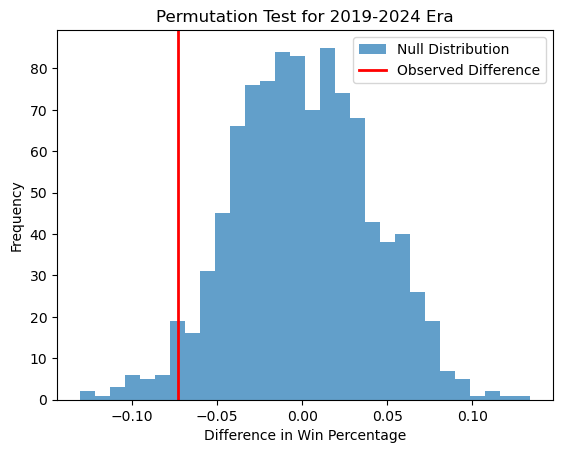

In [68]:
# Plot the permutation distribution
plt.hist(perm_diffs_2024, bins=30, alpha=0.7, label='Null Distribution')
plt.axvline(observed_diff_2024, color='red', linewidth=2, label='Observed Difference')
plt.title(f'Permutation Test for 2019-2024 Era')
plt.xlabel('Difference in Win Percentage')
plt.ylabel('Frequency')
plt.legend()
plt.show()